# **Tugas 4 : Graph**

**Nama : Adz Dzikry Pradana Putra-210411100093**

---

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
import pandas as pd
import numpy as np
import re
import nltk
!pip install Sastrawi
nltk.download('punkt')

from nltk.corpus import stopwords
#stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk

from nltk.tokenize import sent_tokenize

import networkx as nx
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [160]:
# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/PPW-A/report/Tugas-PPW/data_berita_detik.csv")
df.head()

,judul,isi,tanggal,kategori
0,18 Tim yang Lolos FFWS Global Finals 2024 di B...,Jakarta - Rangkaian pertandingan di FFWS SEA 2...,"Rabu, 16 Okt 2024 19:30 WIB",Games
1,Ampun Bang Jago! Zuckerberg Klaim Pemain Handa...,"Jakarta - CEO Meta Mark Zuckerberg, cukup perc...","Rabu, 16 Okt 2024 17:50 WIB",Games
2,"20 Game Horor Terbaik Tahun 2000an, Udah Perna...",Jakarta - Game horor selalu punya daya tarikny...,"Rabu, 16 Okt 2024 14:20 WIB",Games
3,"Begini Cara Dapat Skin Zhou Yu HOK Gratis, Gam...",Jakarta - Ternyata cara dapat skin Zhou Yu Hon...,"Rabu, 16 Okt 2024 12:15 WIB",Games
4,"Gagal Juara FFWS SEA 2024 Fall, Wakil RI: Kita...","Jakarta - Tampil di depan ribuan pendukungnya,...","Selasa, 15 Okt 2024 17:36 WIB",Games


In [161]:
# mengambil satu sample berita
sample_berita = df['isi'].iloc[7] # 8 kalimat
# sample_berita = df['isi'].iloc[4]
print(sample_berita)

Jakarta - Kejuaraan dunia Honor of Kings akan segera diselenggarakan di Indonesia pada 12 Oktober 2024. Ada tiga tim Indonesia yang akan bertanding, yakni Dominator Esports, Kagendra, dan Mahadewa Esports. Ketiga tim tersebut akan bersaing dengan 13 tim lainnya yang berasal dari berbagai macam negara, dalam upaya meraih gelar juara. Namun tak hanya mengejar titel tim Honor of Kings terbaik, mereka juga berusaha keras supaya mendapatkan bagian terbesar dari total hadiah USD 1 juta atau sekitar Rp 15,5 miliar. Pertandingannya dimulai dari fase grup dan knockout stage fase 1 pada 12-18 Oktober 2024 di MGP Space, SCBD, Jakarta. Lalu kompetisinya berlanjut ke knockout stage fase 2 pada 25 Oktober 2024 di Kemang Village Indoor. Setelahnya, pada 26-27 Oktober 2024 2024, ajang bergengsi ini memasuki babak semifinal dan final yang digelar di lokasi sama dengan knockout stage fase 2. Untuk babak grup, dihelat dalam format single round-robin dengan skema best of 3 (Bo3). Kemudian dua tim terbaik 

In [162]:
# Membuat list untuk menyimpan hasil
result_list = []

# Pisahkan kalimat berdasarkan titik
sentences = sample_berita.split('.')  # Pisahkan kalimat berdasarkan titik
sentences = [s.strip() for s in sentences if s.strip()]  # Hilangkan spasi berlebih dan kosong

# Looping untuk menambahkan setiap kalimat ke result_list
for i, sentence in enumerate(sentences, 1):
    result_list.append({'kalimat ke n': f"Kalimat ke {i}", 'kalimat': sentence})

# Membuat DataFrame dari hasil pemisahan
result_df = pd.DataFrame(result_list)

# Tampilkan DataFrame
result_df

,kalimat ke n,kalimat
0,Kalimat ke 1,Jakarta - Kejuaraan dunia Honor of Kings akan ...
1,Kalimat ke 2,"Ada tiga tim Indonesia yang akan bertanding, y..."
2,Kalimat ke 3,Ketiga tim tersebut akan bersaing dengan 13 ti...
3,Kalimat ke 4,Namun tak hanya mengejar titel tim Honor of Ki...
4,Kalimat ke 5,Pertandingannya dimulai dari fase grup dan kno...
5,Kalimat ke 6,Lalu kompetisinya berlanjut ke knockout stage ...
6,Kalimat ke 7,"Setelahnya, pada 26-27 Oktober 2024 2024, ajan..."
7,Kalimat ke 8,"Untuk babak grup, dihelat dalam format single ..."
8,Kalimat ke 9,Kemudian dua tim terbaik dari masing-masing gr...
9,Kalimat ke 10,"Di sini, semua laga akan berlangsung dengan sk..."


In [163]:
# Download stopwords untuk bahasa Indonesia
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

# Fungsi preprocessing yang disesuaikan
def remove_url(data_berita):
    url = re.compile(r'https?://\S+|www\.S+')
    return url.sub(r'', data_berita)

def remove_html(data_berita):
    html = re.compile(r'<.#?>')
    return html.sub(r'', data_berita)

def remove_emoji(data_berita):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data_berita)

def remove_numbers(data_berita):
    data_berita = re.sub(r'\d+', '', data_berita)
    return data_berita

def remove_symbols(data_berita):
    data_berita = re.sub(r'[^a-zA-Z0-9\s]', '', data_berita)
    return data_berita

def case_folding(text):
    if isinstance(text, str):
        return text.lower()
    return text

def tokenize(text):
    return text.split()

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

# Looping setiap kalimat di dataframe 'result_df'
result_df['clean'] = result_df['kalimat'].apply(remove_url)
result_df['clean'] = result_df['clean'].apply(remove_html)
result_df['clean'] = result_df['clean'].apply(remove_emoji)
result_df['clean'] = result_df['clean'].apply(remove_symbols)
result_df['clean'] = result_df['clean'].apply(remove_numbers)
result_df['clean'] = result_df['clean'].apply(case_folding)
result_df['tokenize'] = result_df['clean'].apply(tokenize)
result_df['stopword removal'] = result_df['tokenize'].apply(remove_stopwords)
result_df['stemming'] = result_df['stopword removal'].apply(stemming)

# Gabungkan kata setelah stemming
result_df['final'] = result_df['stemming'].apply(lambda x: ' '.join(x))

# Tampilkan hasil dataframe
result_df[['kalimat ke n', 'final']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,kalimat ke n,final
0,Kalimat ke 1,jakarta juara dunia honor of kings selenggara ...
1,Kalimat ke 2,tim indonesia tanding dominator esports kagend...
2,Kalimat ke 3,tiga tim saing tim asal negara upaya raih gela...
3,Kalimat ke 4,kejar titel tim honor of kings baik usaha kera...
4,Kalimat ke 5,tanding fase grup knockout stage fase oktober ...
5,Kalimat ke 6,kompetisi lanjut knockout stage fase oktober k...
6,Kalimat ke 7,telah oktober ajang gengsi pasuk babak semifin...
7,Kalimat ke 8,babak grup helat format single roundrobin skem...
8,Kalimat ke 9,tim baik masingmasing grup laju knockout stage
9,Kalimat ke 10,laga skema tanding bo kecuali grand final


In [164]:
# Gabungkan semua kalimat hasil stemming menjadi dokumen untuk tiap kalimat
documents = result_df['final'].tolist()

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Terapkan TF-IDF ke dokumen (kalimat yang sudah dipreproses)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Mendapatkan nama-nama fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Mengubah hasil TF-IDF menjadi dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Tambahkan kolom 'no' dan 'kalimat ke n' untuk identifikasi
tfidf_df.insert(0, 'kalimat ke n', result_df['kalimat ke n'])

# Tampilkan dataframe dengan skor TF-IDF
tfidf_df

,kalimat ke n,ajang,alpha,arab,asal,babak,bagi,baik,besar,best,...,titel,total,turki,upaya,usaha,usd,village,vitality,vs,wib
0,Kalimat ke 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Kalimat ke 2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Kalimat ke 3,0.000000,0.000000,0.000000,0.331238,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.331238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Kalimat ke 4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.235335,0.271902,0.000000,...,0.271902,0.271902,0.000000,0.000000,0.271902,0.271902,0.000000,0.000000,0.000000,0.000000
4,Kalimat ke 5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kalimat ke 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382831,0.000000,0.000000,0.000000
6,Kalimat ke 7,0.317589,0.000000,0.000000,0.000000,0.244573,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Kalimat ke 8,0.000000,0.000000,0.000000,0.000000,0.279843,0.000000,0.000000,0.000000,0.363388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Kalimat ke 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.409659,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Kalimat ke 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [165]:
# Menghitung cosine similarity antar kalimat berdasarkan TF-IDF
cosine_sim = cosine_similarity(tfidf_matrix)

# Membuat dataframe untuk menyimpan hasil cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks cosine similarity
cosine_sim_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14
kalimat ke n,,,,,,,,,,,,,,
Kalimat ke 1,1.000000,0.106189,0.104693,0.157518,0.169488,0.065255,0.054134,0.061941,0.000000,0.000000,0.149074,0.223903,0.185750,0.024985
Kalimat ke 2,0.106189,1.000000,0.113582,0.046618,0.059728,0.000000,0.000000,0.000000,0.081150,0.073138,0.080865,0.066264,0.457415,0.338167
Kalimat ke 3,0.104693,0.113582,1.000000,0.072771,0.000000,0.000000,0.078805,0.000000,0.126676,0.000000,0.000000,0.103440,0.000000,0.000000
Kalimat ke 4,0.157518,0.046618,0.072771,1.000000,0.000000,0.000000,0.000000,0.039917,0.148399,0.000000,0.000000,0.186747,0.072642,0.000000
Kalimat ke 5,0.169488,0.059728,0.000000,0.000000,1.000000,0.322241,0.267325,0.061338,0.216112,0.060037,0.066380,0.111233,0.025270,0.020629
Kalimat ke 6,0.065255,0.000000,0.000000,0.000000,0.322241,1.000000,0.221667,0.000000,0.149696,0.000000,0.000000,0.050546,0.012723,0.022670
Kalimat ke 7,0.054134,0.000000,0.078805,0.000000,0.267325,0.221667,1.000000,0.068442,0.124185,0.101489,0.000000,0.114726,0.010555,0.018807
Kalimat ke 8,0.061941,0.000000,0.000000,0.039917,0.061338,0.000000,0.068442,1.000000,0.083337,0.208056,0.230036,0.208082,0.028565,0.000000
Kalimat ke 9,0.000000,0.081150,0.126676,0.148399,0.216112,0.149696,0.124185,0.083337,1.000000,0.000000,0.000000,0.225032,0.015730,0.000000


In [166]:
from sklearn.metrics import jaccard_score

# Fungsi untuk menghitung Jaccard similarity antar vektor
def calculate_jaccard_similarity(tfidf_matrix):
    # Inisialisasi matriks untuk menyimpan hasil Jaccard similarity
    num_sentences = tfidf_matrix.shape[0]
    jaccard_similarity_matrix = np.zeros((num_sentences, num_sentences))

    # Looping untuk menghitung Jaccard similarity antara setiap pasangan kalimat
    for i in range(num_sentences):
        for j in range(num_sentences):
            # Hitung Jaccard similarity berdasarkan vektor biner
            jaccard_similarity_matrix[i, j] = jaccard_score(tfidf_matrix[i].toarray()[0] > 0,
                                                            tfidf_matrix[j].toarray()[0] > 0)
    return jaccard_similarity_matrix

# Hitung Jaccard similarity matriks dari TF-IDF
jaccard_similarity = calculate_jaccard_similarity(tfidf_matrix)

# Membuat DataFrame dari matriks Jaccard similarity
jaccard_df = pd.DataFrame(jaccard_similarity,
                          index=result_df['kalimat ke n'],
                          columns=result_df['kalimat ke n'])

# Tampilkan DataFrame Jaccard similarity
jaccard_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14
kalimat ke n,,,,,,,,,,,,,,
Kalimat ke 1,1.000000,0.066667,0.058824,0.136364,0.117647,0.058824,0.047619,0.055556,0.000000,0.000000,0.071429,0.176471,0.083333,0.028571
Kalimat ke 2,0.066667,1.000000,0.066667,0.045455,0.062500,0.000000,0.000000,0.000000,0.076923,0.076923,0.083333,0.058824,0.136364,0.133333
Kalimat ke 3,0.058824,0.066667,1.000000,0.041667,0.000000,0.000000,0.047619,0.000000,0.066667,0.000000,0.000000,0.052632,0.000000,0.000000
Kalimat ke 4,0.136364,0.045455,0.041667,1.000000,0.000000,0.000000,0.000000,0.040000,0.095238,0.000000,0.000000,0.173913,0.053571,0.000000
Kalimat ke 5,0.117647,0.062500,0.000000,0.000000,1.000000,0.266667,0.210526,0.052632,0.214286,0.062500,0.066667,0.105263,0.039216,0.027778
Kalimat ke 6,0.058824,0.000000,0.000000,0.000000,0.266667,1.000000,0.222222,0.000000,0.142857,0.000000,0.000000,0.052632,0.019608,0.028571
Kalimat ke 7,0.047619,0.000000,0.047619,0.000000,0.210526,0.222222,1.000000,0.045455,0.111111,0.052632,0.000000,0.090909,0.018182,0.025641
Kalimat ke 8,0.055556,0.000000,0.000000,0.040000,0.052632,0.000000,0.045455,1.000000,0.062500,0.133333,0.142857,0.166667,0.019231,0.000000
Kalimat ke 9,0.000000,0.076923,0.066667,0.095238,0.214286,0.142857,0.111111,0.062500,1.000000,0.000000,0.000000,0.200000,0.020408,0.000000


In [167]:
# Tetapkan ambang batas (threshold) 0.7
threshold = 0.05

# Buat matriks adjacency: jika cosine similarity >= 0.6, maka 1; jika tidak, maka 0
adjacency_matrix = np.where(cosine_sim >= threshold, 1, 0)

# Buat dataframe untuk menampilkan matriks adjacency
adjacency_df = pd.DataFrame(adjacency_matrix, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks adjacency
adjacency_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14
kalimat ke n,,,,,,,,,,,,,,
Kalimat ke 1,1,1,1,1,1,1,1,1,0,0,1,1,1,0
Kalimat ke 2,1,1,1,0,1,0,0,0,1,1,1,1,1,1
Kalimat ke 3,1,1,1,1,0,0,1,0,1,0,0,1,0,0
Kalimat ke 4,1,0,1,1,0,0,0,0,1,0,0,1,1,0
Kalimat ke 5,1,1,0,0,1,1,1,1,1,1,1,1,0,0
Kalimat ke 6,1,0,0,0,1,1,1,0,1,0,0,1,0,0
Kalimat ke 7,1,0,1,0,1,1,1,1,1,1,0,1,0,0
Kalimat ke 8,1,0,0,0,1,0,1,1,1,1,1,1,0,0
Kalimat ke 9,0,1,1,1,1,1,1,1,1,0,0,1,0,0


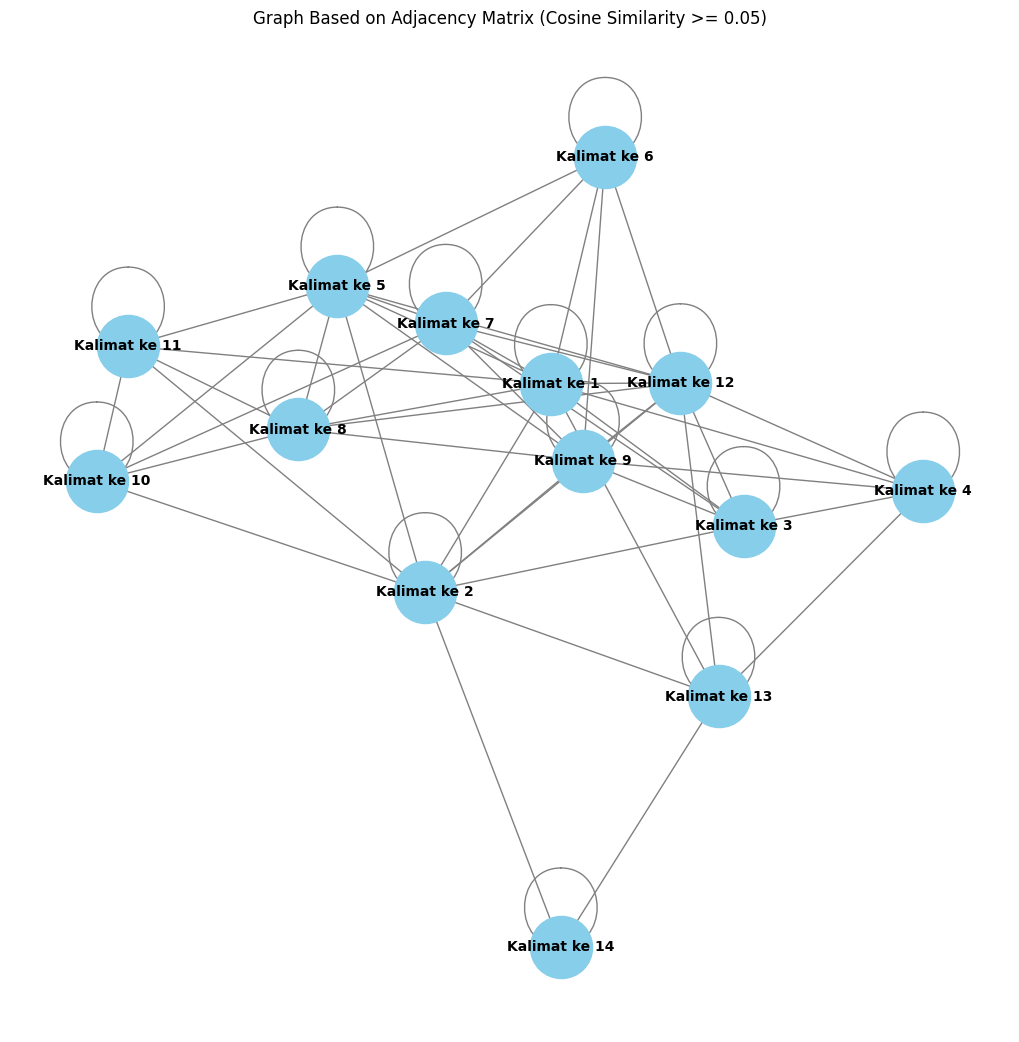

In [168]:
# Buat graf dari matriks adjacency
G = nx.from_numpy_array(adjacency_matrix)

# Atur label node agar sesuai dengan 'kalimat ke n'
mapping = {i: f"Kalimat ke {i+1}" for i in range(len(result_df))}
G = nx.relabel_nodes(G, mapping)

# Menggambar graf
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_color='black', edge_color='gray', linewidths=1, font_weight='bold')

# Tampilkan graf
plt.title("Graph Based on Adjacency Matrix (Cosine Similarity >= 0.05)")
plt.show()

In [169]:
# Menghitung betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Menghitung degree centrality
degree_centrality = nx.degree_centrality(G)

# Menghitung closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Buat dataframe untuk menampilkan hasil centrality
centrality_df = pd.DataFrame({
    'Kalimat': list(betweenness_centrality.keys()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

# Tampilkan dataframe centrality
centrality_df

,Kalimat,Betweenness Centrality,Degree Centrality,Closeness Centrality
0,Kalimat ke 1,0.117468,0.923077,0.812500
1,Kalimat ke 2,0.173130,0.846154,0.764706
2,Kalimat ke 3,0.012714,0.615385,0.650000
3,Kalimat ke 4,0.009081,0.538462,0.590909
4,Kalimat ke 5,0.051870,0.846154,0.764706
5,Kalimat ke 6,0.001603,0.538462,0.590909
6,Kalimat ke 7,0.038141,0.769231,0.684211
7,Kalimat ke 8,0.023665,0.692308,0.650000
8,Kalimat ke 9,0.046154,0.769231,0.722222
9,Kalimat ke 10,0.010684,0.538462,0.590909


In [170]:
top_5_sentences = centrality_df.sort_values(by='Betweenness Centrality', ascending=False).head(5)
top_5_sentences

,Kalimat,Betweenness Centrality,Degree Centrality,Closeness Centrality
1,Kalimat ke 2,0.173130,0.846154,0.764706
0,Kalimat ke 1,0.117468,0.923077,0.812500
11,Kalimat ke 12,0.084081,0.923077,0.812500
4,Kalimat ke 5,0.051870,0.846154,0.764706
8,Kalimat ke 9,0.046154,0.769231,0.722222
